# **Changing to transfer learning with efficientnet b0**

From the previous model, we have swapped out the model for efficientnet b0 that has been pretrained and tweaking it to use our data and classes.


Validation Loss: 0.8605
Validation Accuracy: 91.30%
FLOPS: 0.21G

In [26]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Nathaniel Chang, Tommy Hick
### Student ID: a1821595, a1825267
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 91.30% FLOPs: 0.21G
##################################################################################################################################

In [27]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = './animal/dataset/dataset/'
classes = os.listdir(data_dir)

In [29]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),  # Randomly resize and crop the image
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with probability
        transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip with probability
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


In [30]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [31]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [32]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


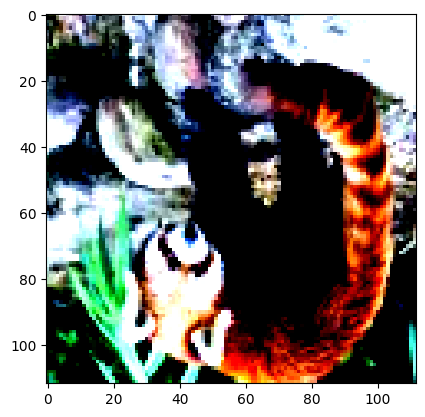

In [33]:
show_image(*dataset[200])

In [34]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [35]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [36]:
batch_size = 8
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


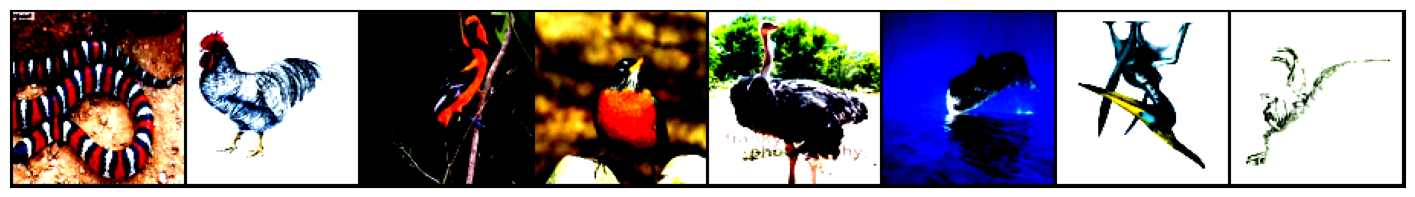

In [37]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [38]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [39]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [41]:
input_size = 3*112*112
output_size = 151

In [42]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = classes

        self.model = models.efficientnet_b0(pretrained=True)

        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, self.num_classes)

    def forward(self, X):
        X = self.model(X)
        return F.log_softmax(X, dim=1)

In [43]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (

In [44]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([8, 3, 112, 112])
out.shape: torch.Size([8, 151])
out[0]: tensor([-5.3306, -5.1478, -4.6661, -4.6892, -4.8743, -5.4414, -5.1203, -5.2616,
        -5.0763, -5.2150, -4.8569, -4.2328, -4.2651, -4.9740, -5.8967, -4.8240,
        -4.7153, -5.2438, -5.9391, -4.8895, -4.1349, -5.4026, -4.4439, -5.4200,
        -4.7755, -5.4014, -4.2853, -5.0213, -5.3200, -5.0363, -4.8848, -5.0683,
        -4.9752, -4.8050, -5.2937, -4.3433, -5.4060, -4.4473, -4.7193, -5.4616,
        -4.9635, -5.3621, -5.7129, -5.0883, -4.8706, -5.0065, -4.6918, -4.7496,
        -4.8032, -5.0112, -4.9375, -5.1954, -5.3248, -4.8421, -5.0990, -5.6386,
        -5.3078, -5.0376, -5.0106, -5.0876, -5.7190, -5.3046, -5.2521, -4.9910,
        -5.1990, -5.4892, -4.5919, -5.4890, -5.5808, -5.3988, -5.6106, -5.2343,
        -5.4663, -4.3562, -5.1467, -5.4533, -5.1481, -5.3110, -4.9424, -5.7410,
        -5.0600, -4.8960, -4.8630, -4.1390, -4.9727, -4.9667, -4.8241, -5.3833,
        -4.6636, -4.5892, -5.3594, -5

In [45]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (

In [46]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
model = to_device(model, device)

In [48]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.034629821777344, 'val_acc': 0.01875000074505806}]

In [49]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 12
opt_func = torch.optim.AdamW
lr = 1e-4

627


In [50]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.4882, val_loss: 3.5946, val_acc: 0.5719


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.9778, val_loss: 2.1140, val_acc: 0.7500


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.1107, val_loss: 1.5449, val_acc: 0.8063


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.6258, val_loss: 1.3110, val_acc: 0.8438


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.3064, val_loss: 1.1435, val_acc: 0.8500


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.0760, val_loss: 1.0273, val_acc: 0.8813


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.9121, val_loss: 1.0137, val_acc: 0.8781


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7634, val_loss: 0.9898, val_acc: 0.8875


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6517, val_loss: 0.8805, val_acc: 0.8875


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5850, val_loss: 0.8516, val_acc: 0.8969


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5112, val_loss: 0.9048, val_acc: 0.9094


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4621, val_loss: 0.8567, val_acc: 0.8938


In [51]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

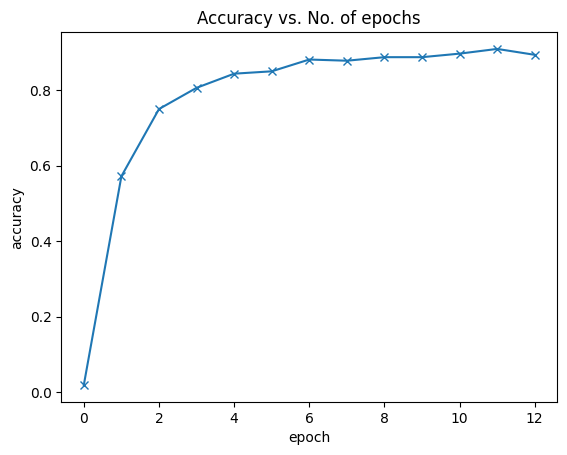

In [52]:
plot_accuracies(history)

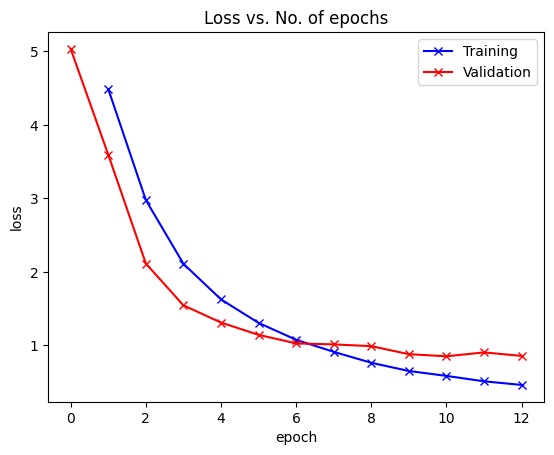

In [53]:
plot_losses(history)

In [54]:
evaluate(model, test_loader)

{'val_loss': 0.8605183959007263, 'val_acc': 0.9129747152328491}

## FLOPs

In [55]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.21G
